OAK - logo generation

doc: https://github.com/openaiknowledge/pr3

Based on Neural style transfer: https://www.tensorflow.org/tutorials/generative/style_transfer

### Import and configure modules

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.utils 
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy as np

from google.colab import drive

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds

import pathlib

import time


In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

## Visualize the input

In [5]:
MIN_DIM = 128 #if it´s smaller -> error 
MAX_DIM = 512

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [6]:
def load_img(path_to_img, max_dim):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

## Load Dataset

In [8]:
BASE_FOLDER = '/content/drive/My Drive/openaiknowledge/pr3/'
DATA = BASE_FOLDER + 'data/1/' #version 1
IMAGES = DATA + "images/"
MODEL = BASE_FOLDER + "model/1/"
IMAGES_OUT_TRAINING = IMAGES + "out_training/"
IMAGES_GENERATED = IMAGES + "generated/"

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(-0.5, 510.5, 511.5, -0.5)

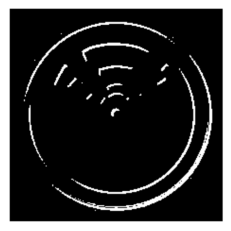

In [10]:
image_path = IMAGES + "generated/" + "hal_cvae.png"
hal = load_img(image_path, MAX_DIM)
hal = hal[0]
plt.imshow(hal)
plt.axis("off")

## Fast Style Transfer using TF-Hub

We use [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) 


In [11]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

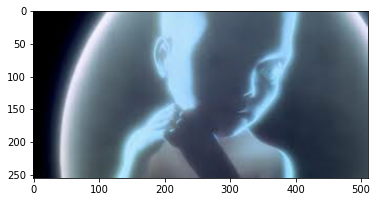

In [12]:
path_hal_styled = IMAGES + "space/space_odyssey_11.jpeg" #tested with other space_odyssey_xx.jpeg
hal_styled = load_img(path_hal_styled,MAX_DIM)
plt.imshow(hal_styled[0])

In [13]:
def generate_and_save_image(content_image_path,base_styled_image_path,max_size):
  content_image = load_img(content_image_path,max_size)[0]
  base_styled = load_img(base_styled_image_path,max_size)
  l_content_image = np.resize(content_image, (1,content_image.shape[0], content_image.shape[1],content_image.shape[2]))
  stylized_image = hub_model(tf.constant(l_content_image), tf.constant(base_styled))[0]
  image_to_save = tensor_to_image(stylized_image)
  max_size_str = str(max_size)
  path_image_to_save =  IMAGES_GENERATED + "logo_"+ max_size_str + "x"+max_size_str +".png"
  image_to_save.save(path_image_to_save)

In [14]:
for i in range(4):
  max_size = MIN_DIM*(2**i)
  generate_and_save_image(image_path, path_hal_styled,max_size)